<a href="https://colab.research.google.com/github/GaganBP/Heart-Disease-Prediction-Comprehensive-ML-Algorithm-Comparison/blob/main/Phase2HeartDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/Colab Notebooks")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Initialization

In [14]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import itertools
import pandas as pd
from tensorflow.keras import metrics
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.optimizers import SGD
from tensorflow.python.keras.utils import np_utils
from keras import metrics
from sklearn.metrics import confusion_matrix
from keras import regularizers
from sklearn.metrics import roc_curve, auc, precision_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
# Set Matplotlib to use a default font available in Colab (e.g., 'Liberation Sans')
plt.rcParams['font.family'] = 'Liberation Sans'
#matplotlib.rcParams['font.family'] = "Times New Roman"

np.random.seed(306)  # for reproducibility

# network and training
NB_EPOCH = 90
BATCH_SIZE = 1024
VERBOSE = 0
NB_CLASSES = 2   # Heart Disease diagnosis yes = 1, no = 0
OPTIMIZER = Adam() # optimizer
N_HIDDEN = 128
TRAINING_SPLIT = 0.6 # how much from all of the data is split for training
VALIDATION_SPLIT=0.4 # how much in TRAIN is reserved for VALIDATION
DROPOUT = 0.5

Data Preparation

In [15]:
# read synthetic cleveland dataset from full cleveland.data
df_main = pd.read_table("syn_cleveland.csv", sep=',')

# Neural Net transfer function likes to work with floats
df_main.astype(float)

# Normalize values to range [0:1]
df_main /= df_main.max()

# split data into independent and dependent variables
y_all = df_main['num']
X_all = df_main.drop(columns = 'num')

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size = TRAINING_SPLIT, test_size = 1 - TRAINING_SPLIT)
Y_train = np_utils.to_categorical( y_train, NB_CLASSES)
Y_test = np_utils.to_categorical( y_test, NB_CLASSES)

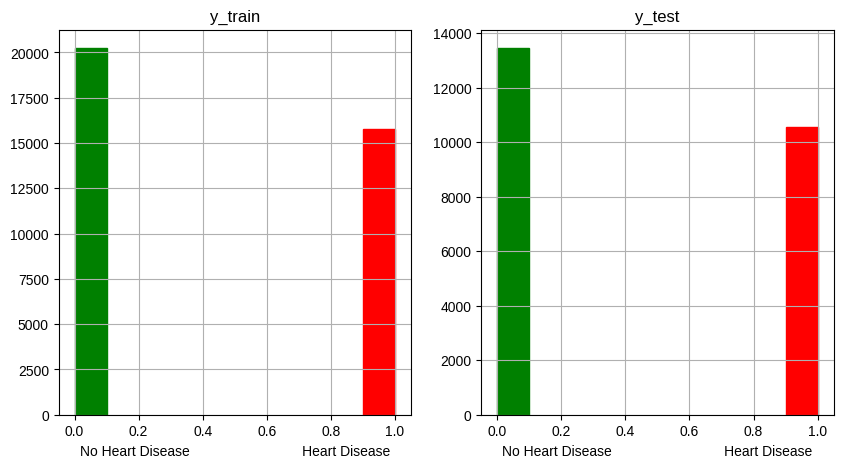

In [16]:
# check class distributions for label balance
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,5))

# plot histograms
axs[0].set_xlabel('No Heart Disease                             Heart Disease')
axs[0].set_title('y_train')
axs[0].grid()
axs[0].hist(y_train)
axs[0].get_children()[0].set_color('g')
axs[0].get_children()[9].set_color('r')
axs[1].set_title('y_test')
axs[1].set_xlabel('No Heart Disease                             Heart Disease')
axs[1].grid()
axs[1].hist(y_test)
axs[1].get_children()[0].set_color('g')
axs[1].get_children()[9].set_color('r')
plt.show()

In [17]:
# check that all inputs are normalized to range [0:1]
X_all.describe().T

,count,mean,std,min,25%,50%,75%,max
age,60000.0,0.705943,0.117166,0.376623,0.610390,0.714286,0.792208,1.0
sex,60000.0,0.677217,0.467545,0.000000,0.000000,1.000000,1.000000,1.0
cp,60000.0,0.791971,0.237629,0.250000,0.750000,0.750000,1.000000,1.0
trestbps,60000.0,0.658369,0.087869,0.470000,0.600000,0.650000,0.700000,1.0
htn,60000.0,0.619883,0.485419,0.000000,0.000000,1.000000,1.000000,1.0
chol,60000.0,0.440395,0.090281,0.223404,0.375887,0.432624,0.489362,1.0
cigs,60000.0,0.171115,0.197728,0.000000,0.000000,0.101010,0.303030,1.0
years,60000.0,0.284111,0.284203,0.000000,0.000000,0.277778,0.555556,1.0
fbs,60000.0,0.153167,0.360151,0.000000,0.000000,0.000000,0.000000,1.0
famhist,60000.0,0.623950,0.484397,0.000000,0.000000,1.000000,1.000000,1.0


Neural Net Setup, Train and Validation

In [18]:
# set up the NN model, Dropout & L2 regularization
model = Sequential()
model.add(Dense(N_HIDDEN, input_shape=(37,), kernel_regularizer = regularizers.l2( 0.01)))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,658 (213.51 KB)

 Trainable params: 54,658 (213.51 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import keras_metrics
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

AttributeError: module 'keras.api.backend' has no attribute 'variable'

In [24]:
from tensorflow.keras.metrics import Precision, Recall

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy', Precision(), Recall()])


In [25]:
print(model.metrics_names) # metrics to retrieve from score after evaluation

['loss', 'compile_metrics']


In [26]:
model.metrics_names

['loss', 'compile_metrics']

In [27]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, optimizers
#from sklearn import s.vm, datasets

In [28]:
names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'Class']
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', names=names)
#data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data', names=names)
data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Class
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [29]:
data.x11.value_counts()

,count
x11,
1.0,142
2.0,140
3.0,21


In [30]:
data.x12.value_counts()

,count
x12,
0.0,176
1.0,65
2.0,38
3.0,20
?,4


In [31]:
data.x13.value_counts()

,count
x13,
3.0,166
7.0,117
6.0,18
?,2


In [32]:

outliers = data.x13[(data.x13 == '?')]
print(outliers)

87     ?
266    ?
Name: x13, dtype: object


In [33]:
data.x13 = data.x13.replace(to_replace =['?'], value =np.nan)
data.x12 = data.x12.replace(to_replace =['?'], value =np.nan)

In [34]:
data.x13.isnull().any()

np.True_

In [35]:
data.Class.value_counts()

,count
Class,
0,164
1,55
2,36
3,35
4,13


In [36]:
data.Class = data.Class.replace(to_replace =[1, 2, 3, 4], value =1)

In [37]:
data = data.dropna()
data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Class
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


In [38]:
data.Class.value_counts()

,count
Class,
0,160
1,137


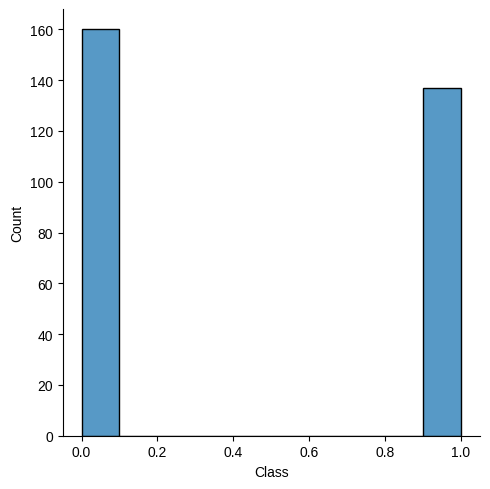

In [39]:
sns.displot(data.Class, kind='hist')

In [40]:
data.dtypes

,0
x1,float64
x2,float64
x3,float64
x4,float64
x5,float64
x6,float64
x7,float64
x8,float64
x9,float64
x10,float64


In [41]:

data.x12 = data.x12.astype(float)
data.x13 = data.x13.astype(float)

<ipython-input-41-43f0dd148b37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.x12 = data.x12.astype(float)
<ipython-input-41-43f0dd148b37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.x13 = data.x13.astype(float)


This is not in original code but added just to solve above warning

In [43]:
data.loc[:, 'x12'] = data['x12'].astype(float)
data.loc[:, 'x13'] = data['x13'].astype(float)

In [44]:
data.dtypes

,0
x1,float64
x2,float64
x3,float64
x4,float64
x5,float64
x6,float64
x7,float64
x8,float64
x9,float64
x10,float64


In [45]:
from sklearn.preprocessing import StandardScaler
def standardscal(s,c,cc):
  x = (cc+'sc')
  sc = StandardScaler()
  c[x] = sc.fit_transform(s)
  c.pop(cc)
  return c[x]

In [46]:

standardscal((data[['x1']]), data, ('x1'))
standardscal((data[['x2']]), data, ('x2'))
standardscal((data[['x3']]), data, ('x3'))
standardscal((data[['x4']]), data, ('x4'))
standardscal((data[['x5']]), data, ('x5'))
standardscal((data[['x6']]), data, ('x6'))
standardscal((data[['x7']]), data, ('x7'))
standardscal((data[['x8']]), data, ('x8'))

<ipython-input-45-e600a701e6ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c[x] = sc.fit_transform(s)
<ipython-input-45-e600a701e6ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c[x] = sc.fit_transform(s)
<ipython-input-45-e600a701e6ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,x8sc
0,0.017494
1,-1.816334
2,-0.899420
3,1.633010
4,0.978071
...,...
297,-1.161395
298,-0.768432
299,-0.375469
300,-1.510696


In [47]:
standardscal((data[['x9']]), data, ('x9'))
standardscal((data[['x10']]), data, ('x10'))
standardscal((data[['x11']]), data, ('x11'))
standardscal((data[['x12']]), data, ('x12'))
standardscal((data[['x13']]), data, ('x13'))

<ipython-input-45-e600a701e6ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c[x] = sc.fit_transform(s)
<ipython-input-45-e600a701e6ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c[x] = sc.fit_transform(s)
<ipython-input-45-e600a701e6ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,x13sc
0,0.655877
1,-0.894220
2,1.172577
3,-0.894220
4,-0.894220
...,...
297,1.172577
298,1.172577
299,1.172577
300,1.172577


In [48]:
data.dtypes

,0
Class,int64
x1sc,float64
x2sc,float64
x3sc,float64
x4sc,float64
x5sc,float64
x6sc,float64
x7sc,float64
x8sc,float64
x9sc,float64


In [49]:
data.corr()

,Class,x1sc,x2sc,x3sc,x4sc,x5sc,x6sc,x7sc,x8sc,x9sc,x10sc,x11sc,x12sc,x13sc
Class,1.000000,0.227075,0.278467,0.408945,0.153490,0.080285,0.003167,0.166343,-0.423817,0.421355,0.424052,0.333049,0.463189,0.526640
x1sc,0.227075,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.126586
x2sc,0.278467,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.383652
x3sc,0.408945,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.268500
x4sc,0.153490,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.138183
x5sc,0.080285,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.010859
x6sc,0.003167,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.062209
x7sc,0.166343,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.018795
x8sc,-0.423817,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.274831
x9sc,0.421355,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.326927


In [50]:
#data = data.drop(['x2','x5','x6','x9'],axis=1)
data = data.drop(['x5sc','x6sc','x8sc'],axis=1)


data.dtypes

,0
Class,int64
x1sc,float64
x2sc,float64
x3sc,float64
x4sc,float64
x7sc,float64
x9sc,float64
x10sc,float64
x11sc,float64
x12sc,float64


In [51]:
data.isnull().any()

,0
Class,False
x1sc,False
x2sc,False
x3sc,False
x4sc,False
x7sc,False
x9sc,False
x10sc,False
x11sc,False
x12sc,False


In [52]:
data.corr()

,Class,x1sc,x2sc,x3sc,x4sc,x7sc,x9sc,x10sc,x11sc,x12sc,x13sc
Class,1.000000,0.227075,0.278467,0.408945,0.153490,0.166343,0.421355,0.424052,0.333049,0.463189,0.526640
x1sc,0.227075,1.000000,-0.092399,0.110471,0.290476,0.149917,0.096489,0.197123,0.159405,0.362210,0.126586
x2sc,0.278467,-0.092399,1.000000,0.008908,-0.066340,0.033897,0.143581,0.106567,0.033345,0.091925,0.383652
x3sc,0.408945,0.110471,0.008908,1.000000,-0.036980,0.063905,0.377525,0.203244,0.151079,0.235644,0.268500
x4sc,0.153490,0.290476,-0.066340,-0.036980,1.000000,0.149242,0.066691,0.191243,0.121172,0.097954,0.138183
x7sc,0.166343,0.149917,0.033897,0.063905,0.149242,1.000000,0.081874,0.113726,0.135141,0.129021,0.018795
x9sc,0.421355,0.096489,0.143581,0.377525,0.066691,0.081874,1.000000,0.289310,0.250572,0.148232,0.326927
x10sc,0.424052,0.197123,0.106567,0.203244,0.191243,0.113726,0.289310,1.000000,0.579037,0.294452,0.344976
x11sc,0.333049,0.159405,0.033345,0.151079,0.121172,0.135141,0.250572,0.579037,1.000000,0.109761,0.279688
x12sc,0.463189,0.362210,0.091925,0.235644,0.097954,0.129021,0.148232,0.294452,0.109761,1.000000,0.256382


In [53]:
fitur = data.drop(columns='Class').values
label = data['Class']


X_train, X_test, y_train, y_test = train_test_split(fitur, label, test_size=0.3, random_state=20)

In [54]:
model = Sequential()
model.add(Dense(50, input_dim=10, activation='relu'))
'''model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))'''
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(learning_rate=0.01), metrics=['accuracy','mae', 'mse'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.4798 - loss: 0.8630 - mae: 0.5211 - mse: 0.3214 - val_accuracy: 0.4222 - val_loss: 0.8530 - val_mae: 0.5247 - val_mse: 0.3209
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4769 - loss: 0.8248 - mae: 0.5153 - mse: 0.3079 - val_accuracy: 0.4222 - val_loss: 0.8199 - val_mae: 0.5156 - val_mse: 0.3072
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4715 - loss: 0.8091 - mae: 0.5114 - mse: 0.3005 - val_accuracy: 0.4222 - val_loss: 0.7902 - val_mae: 0.5069 - val_mse: 0.2945
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4814 - loss: 0.7839 - mae: 0.5017 - mse: 0.2899 - val_accuracy: 0.4333 - val_loss: 0.7637 - val_mae: 0.4984 - val_mse: 0.2828
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4788 - loss: 0.7537 - mae: 0.4972 - mse: 0.2780 - val_accuracy: 0.4667 - val_loss: 0.7390 - val_mae: 0.4898 - val_mse: 0.2717
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 

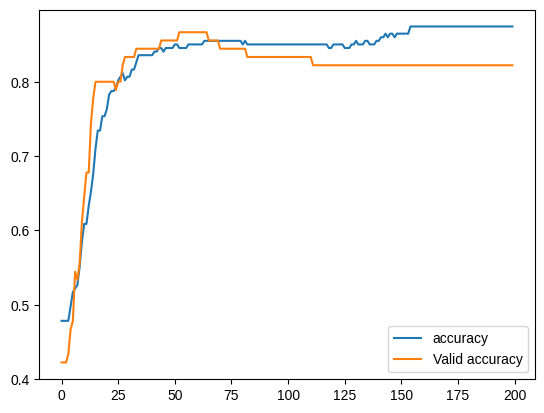

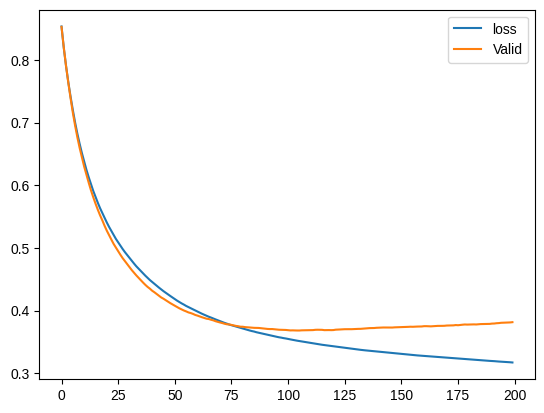

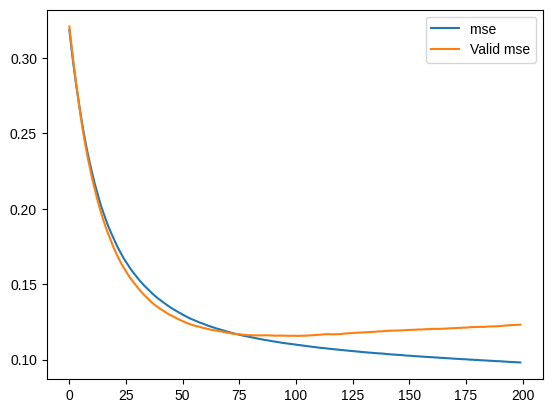

In [56]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='Valid accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='Valid mse')
plt.legend()
plt.show()

In [57]:
import numpy as np

# Assuming X_train and X_test are 2D arrays
# Reshape the input data to add a timestep dimension
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

In [58]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import SGD
import numpy as np

# Assuming X_train and X_test are 2D arrays
# Reshape the input data to add a timestep dimension
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=['accuracy', 'mae', 'mse'])

history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=200, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - accuracy: 0.4180 - loss: 0.6967 - mae: 0.5017 - mse: 0.2518 - val_accuracy: 0.6000 - val_loss: 0.6898 - val_mae: 0.4983 - val_mse: 0.2483
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5556 - loss: 0.6903 - mae: 0.4985 - mse: 0.2486 - val_accuracy: 0.7667 - val_loss: 0.6852 - val_mae: 0.4960 - val_mse: 0.2460
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6545 - loss: 0.6865 - mae: 0.4966 - mse: 0.2467 - val_accuracy: 0.8222 - val_loss: 0.6810 - val_mae: 0.4938 - val_mse: 0.2439
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7457 - loss: 0.6816 - mae: 0.4941 - mse: 0.2442 - val_accuracy: 0.8556 - val_loss: 0.6769 - val_mae: 0.4917 - val_mse: 0.2419
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7786 - loss: 0.6773 - mae: 0.4919 - mse: 0.2421 - val_accuracy: 0.8556 - val_loss: 0.6729 - val_mae: 0.4897 - val_mse: 0.2399
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/ste

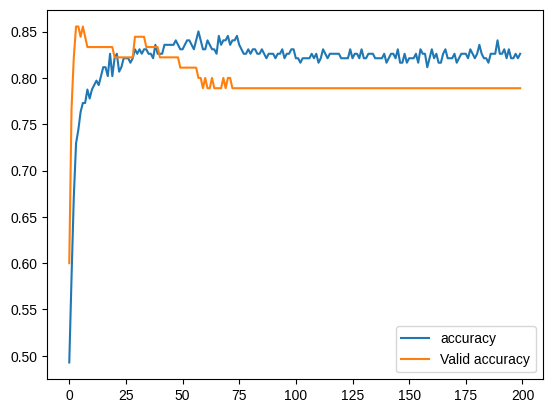

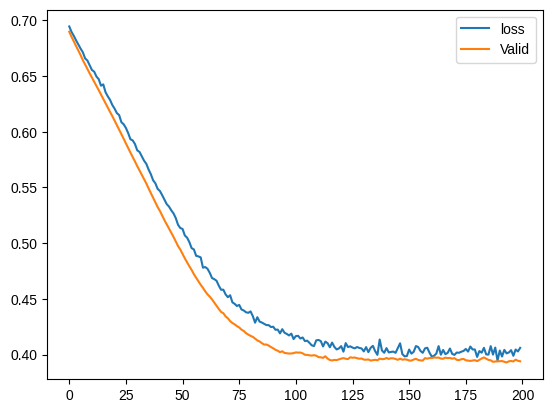

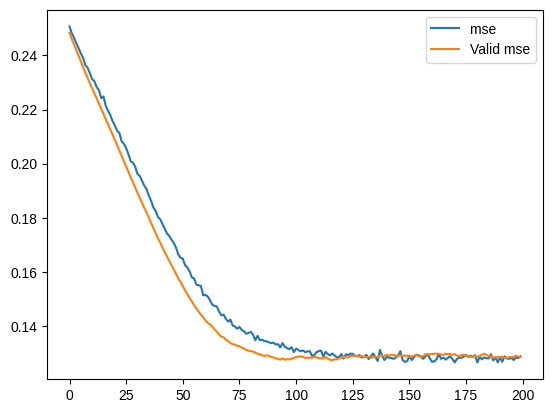

In [59]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='Valid accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='Valid mse')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.78      0.84      0.81        38

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.84      0.83      0.83        90



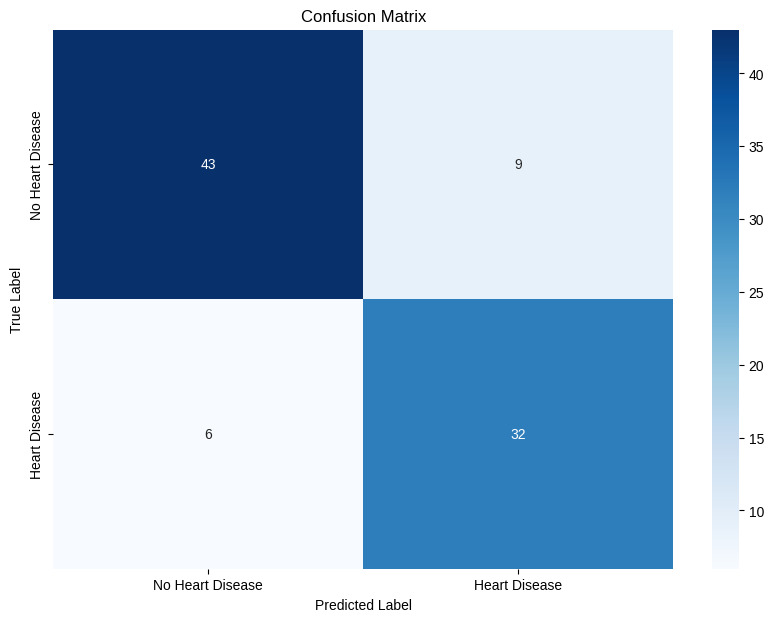

In [60]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize the SVM classifier
svm_model = svm.SVC(kernel='linear', probability=True)

# Train the SVM classifier
svm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.78      0.84      0.81        38

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.84      0.83      0.83        90



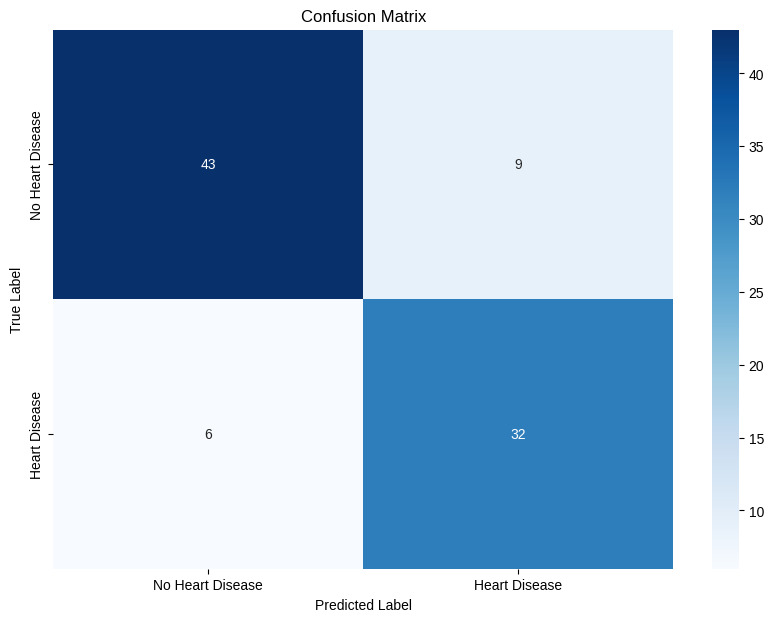

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Logistic Regression classifier
lr_model = LogisticRegression()

# Train the Logistic Regression classifier
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        52
           1       0.70      0.79      0.74        38

    accuracy                           0.77        90
   macro avg       0.76      0.77      0.76        90
weighted avg       0.77      0.77      0.77        90



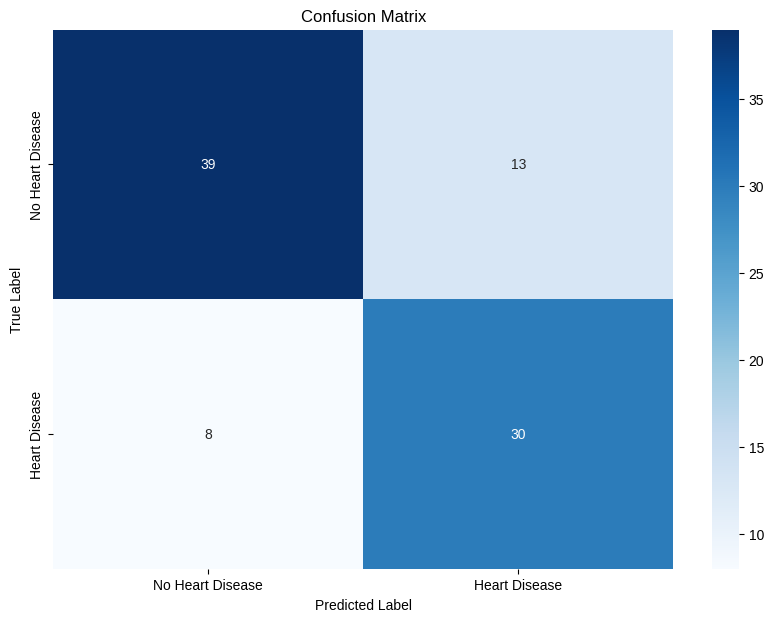

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Train the Decision Tree classifier
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        52
           1       0.79      0.87      0.82        38

    accuracy                           0.84        90
   macro avg       0.84      0.85      0.84        90
weighted avg       0.85      0.84      0.85        90



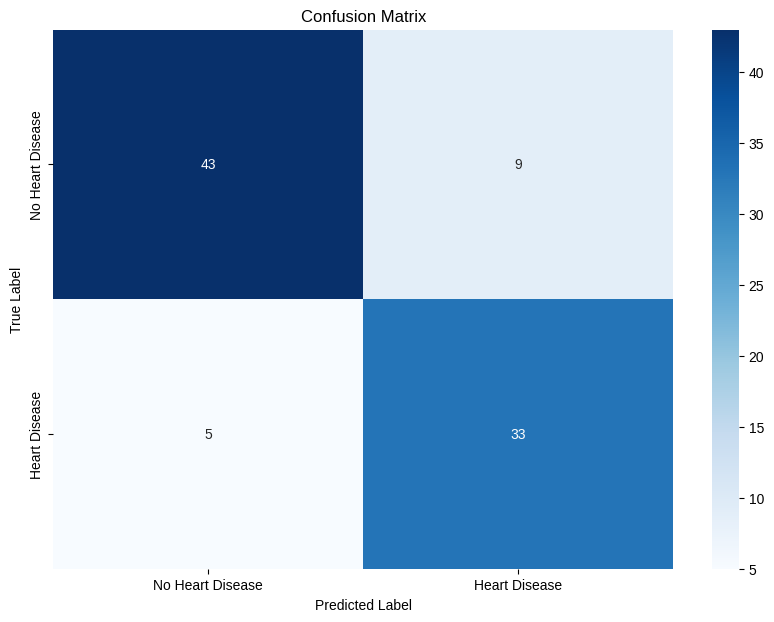

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier()

# Train the Random Forest classifier
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        52
           1       0.74      0.89      0.81        38

    accuracy                           0.82        90
   macro avg       0.82      0.83      0.82        90
weighted avg       0.84      0.82      0.82        90



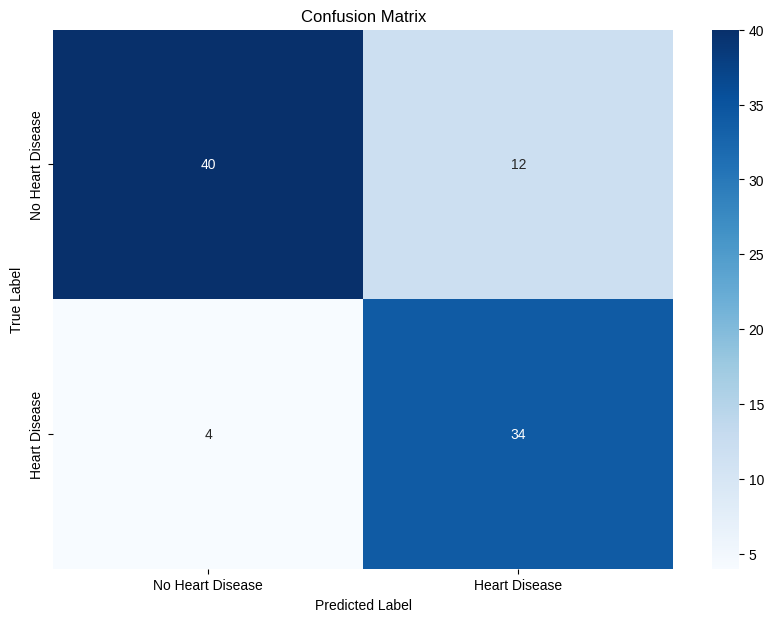

In [64]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the XGBoost classifier
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


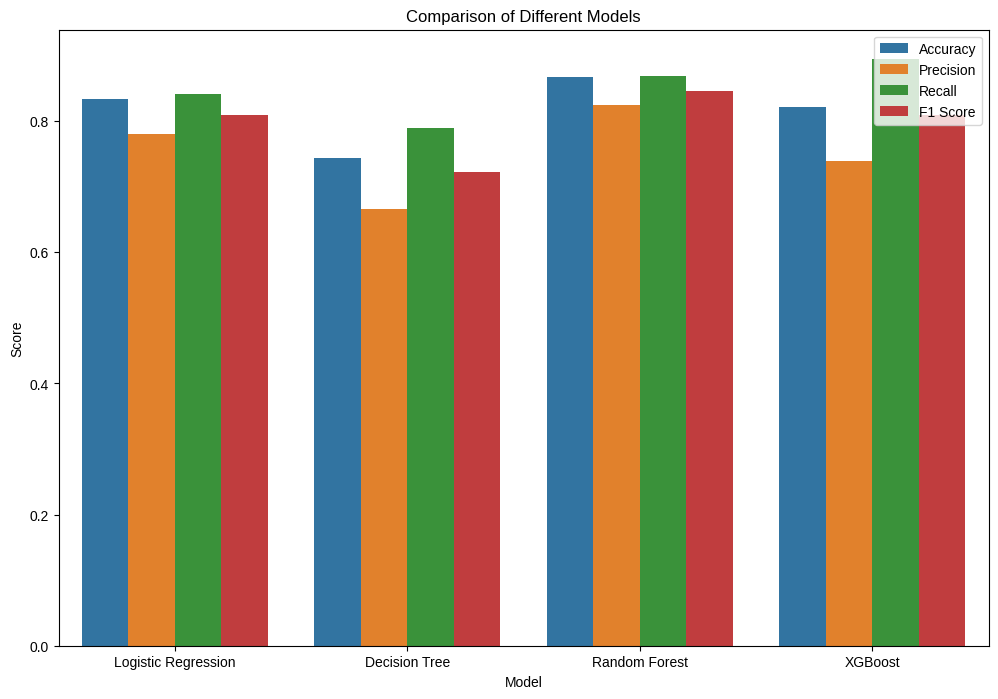

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming the dataset has already been preprocessed and split into X_train, X_test, y_train, y_test

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# Train the models and make predictions
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1 Score'].append(f1_score(y_test, y_pred))

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot the metrics
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(metrics_df, id_vars=['Model']))
plt.title('Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.show()


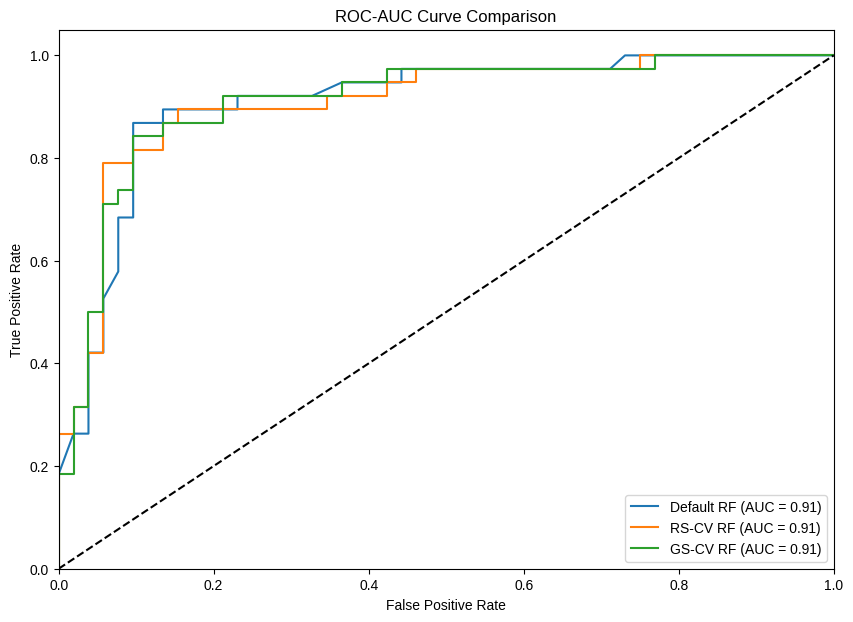

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the dataset has already been preprocessed and split into X_train, X_test, y_train, y_test

# 1. Default Random Forest Model
rf_default = RandomForestClassifier()
rf_default.fit(X_train, y_train)
y_prob_default = rf_default.predict_proba(X_test)[:, 1]

# 2. Random Search Cross-Validation (RS-CV)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rs_cv = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=10, scoring='roc_auc', cv=5, random_state=42)
rs_cv.fit(X_train, y_train)
y_prob_rscv = rs_cv.predict_proba(X_test)[:, 1]

# 3. Grid Search Cross-Validation (GS-C)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gs_cv = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc', cv=5)
gs_cv.fit(X_train, y_train)
y_prob_gscv = gs_cv.predict_proba(X_test)[:, 1]

# Plot ROC curves
plt.figure(figsize=(10, 7))
fpr_default, tpr_default, _ = roc_curve(y_test, y_prob_default)
fpr_rscv, tpr_rscv, _ = roc_curve(y_test, y_prob_rscv)
fpr_gscv, tpr_gscv, _ = roc_curve(y_test, y_prob_gscv)

plt.plot(fpr_default, tpr_default, label=f'Default RF (AUC = {roc_auc_score(y_test, y_prob_default):.2f})')
plt.plot(fpr_rscv, tpr_rscv, label=f'RS-CV RF (AUC = {roc_auc_score(y_test, y_prob_rscv):.2f})')
plt.plot(fpr_gscv, tpr_gscv, label=f'GS-CV RF (AUC = {roc_auc_score(y_test, y_prob_gscv):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


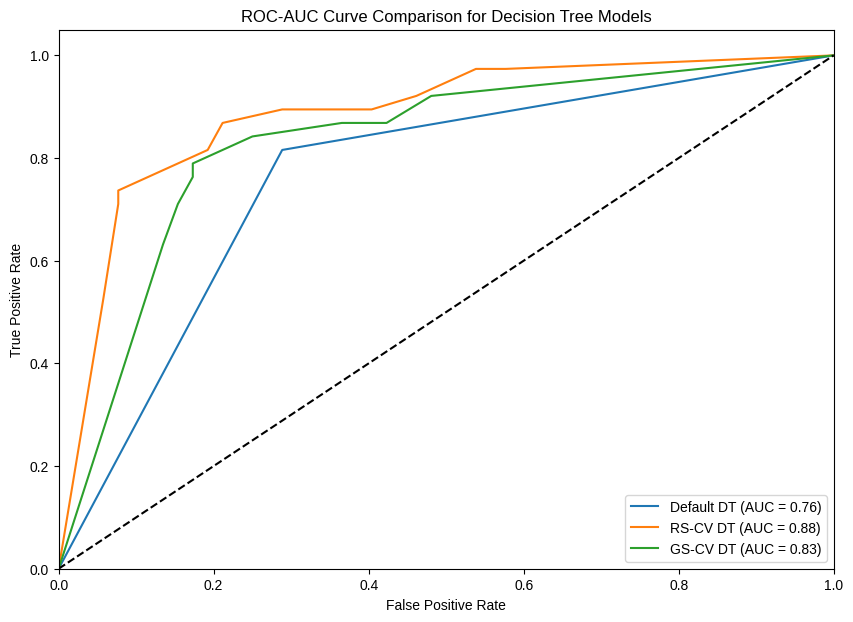

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the dataset has already been preprocessed and split into X_train, X_test, y_train, y_test

# 1. Default Decision Tree Model
dt_default = DecisionTreeClassifier()
dt_default.fit(X_train, y_train)
y_prob_default = dt_default.predict_proba(X_test)[:, 1]

# 2. Random Search Cross-Validation (RS-CV)
param_dist = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}
rs_cv = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, n_iter=10, scoring='roc_auc', cv=5, random_state=42)
rs_cv.fit(X_train, y_train)
y_prob_rscv = rs_cv.predict_proba(X_test)[:, 1]

# 3. Grid Search Cross-Validation (GS-CV)
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gs_cv = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', cv=5)
gs_cv.fit(X_train, y_train)
y_prob_gscv = gs_cv.predict_proba(X_test)[:, 1]

# Plot ROC curves
plt.figure(figsize=(10, 7))
fpr_default, tpr_default, _ = roc_curve(y_test, y_prob_default)
fpr_rscv, tpr_rscv, _ = roc_curve(y_test, y_prob_rscv)
fpr_gscv, tpr_gscv, _ = roc_curve(y_test, y_prob_gscv)

plt.plot(fpr_default, tpr_default, label=f'Default DT (AUC = {roc_auc_score(y_test, y_prob_default):.2f})')
plt.plot(fpr_rscv, tpr_rscv, label=f'RS-CV DT (AUC = {roc_auc_score(y_test, y_prob_rscv):.2f})')
plt.plot(fpr_gscv, tpr_gscv, label=f'GS-CV DT (AUC = {roc_auc_score(y_test, y_prob_gscv):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison for Decision Tree Models')
plt.legend(loc='lower right')
plt.show()


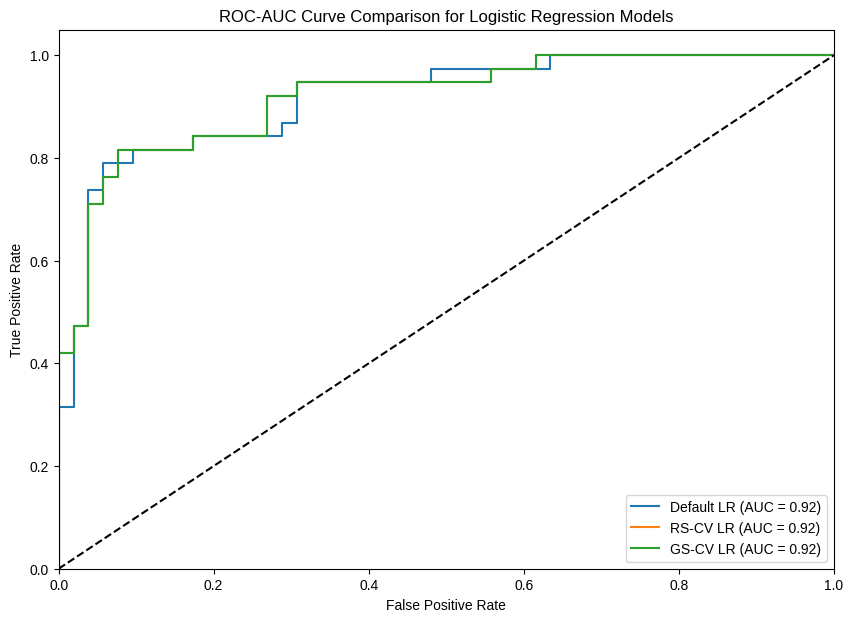

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt

# Assuming the dataset has already been preprocessed and split into X_train, X_test, y_train, y_test

# 1. Default Logistic Regression Model
lr_default = LogisticRegression()
lr_default.fit(X_train, y_train)
y_prob_default = lr_default.predict_proba(X_test)[:, 1]

# 2. Random Search Cross-Validation (RS-CV)
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
rs_cv = RandomizedSearchCV(LogisticRegression(), param_dist, n_iter=10, scoring='roc_auc', cv=5, random_state=42)
rs_cv.fit(X_train, y_train)
y_prob_rscv = rs_cv.predict_proba(X_test)[:, 1]

# 3. Grid Search Cross-Validation (GS-CV)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
gs_cv = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=5)
gs_cv.fit(X_train, y_train)
y_prob_gscv = gs_cv.predict_proba(X_test)[:, 1]

# Plot ROC curves
plt.figure(figsize=(10, 7))
fpr_default, tpr_default, _ = roc_curve(y_test, y_prob_default)
fpr_rscv, tpr_rscv, _ = roc_curve(y_test, y_prob_rscv)
fpr_gscv, tpr_gscv, _ = roc_curve(y_test, y_prob_gscv)

plt.plot(fpr_default, tpr_default, label=f'Default LR (AUC = {roc_auc_score(y_test, y_prob_default):.2f})')
plt.plot(fpr_rscv, tpr_rscv, label=f'RS-CV LR (AUC = {roc_auc_score(y_test, y_prob_rscv):.2f})')
plt.plot(fpr_gscv, tpr_gscv, label=f'GS-CV LR (AUC = {roc_auc_score(y_test, y_prob_gscv):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison for Logistic Regression Models')
plt.legend(loc='lower right')
plt.show()


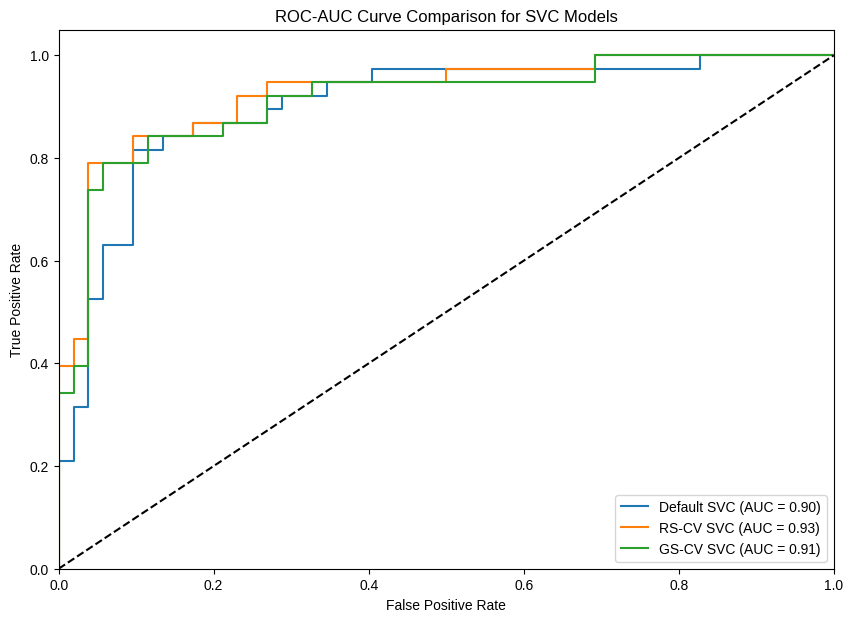

In [69]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Assuming the dataset has already been preprocessed and split into X_train, X_test, y_train, y_test

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. Default SVC Model
svc_default = SVC(probability=True)
svc_default.fit(X_train, y_train)
y_prob_default = svc_default.predict_proba(X_test)[:, 1]

# 2. Random Search Cross-Validation (RS-CV)
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-4, 1e-5],
    'kernel': ['rbf', 'linear']
}
rs_cv = RandomizedSearchCV(SVC(probability=True), param_dist, n_iter=10, scoring='roc_auc', cv=5, random_state=42)
rs_cv.fit(X_train, y_train)
y_prob_rscv = rs_cv.predict_proba(X_test)[:, 1]

# 3. Grid Search Cross-Validation (GS-CV)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-4],
    'kernel': ['rbf']
}
gs_cv = GridSearchCV(SVC(probability=True), param_grid, scoring='roc_auc', cv=5)
gs_cv.fit(X_train, y_train)
y_prob_gscv = gs_cv.predict_proba(X_test)[:, 1]

# Plot ROC curves
plt.figure(figsize=(10, 7))
fpr_default, tpr_default, _ = roc_curve(y_test, y_prob_default)
fpr_rscv, tpr_rscv, _ = roc_curve(y_test, y_prob_rscv)
fpr_gscv, tpr_gscv, _ = roc_curve(y_test, y_prob_gscv)

plt.plot(fpr_default, tpr_default, label=f'Default SVC (AUC = {roc_auc_score(y_test, y_prob_default):.2f})')
plt.plot(fpr_rscv, tpr_rscv, label=f'RS-CV SVC (AUC = {roc_auc_score(y_test, y_prob_rscv):.2f})')
plt.plot(fpr_gscv, tpr_gscv, label=f'GS-CV SVC (AUC = {roc_auc_score(y_test, y_prob_gscv):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison for SVC Models')
plt.legend(loc='lower right')
plt.show()


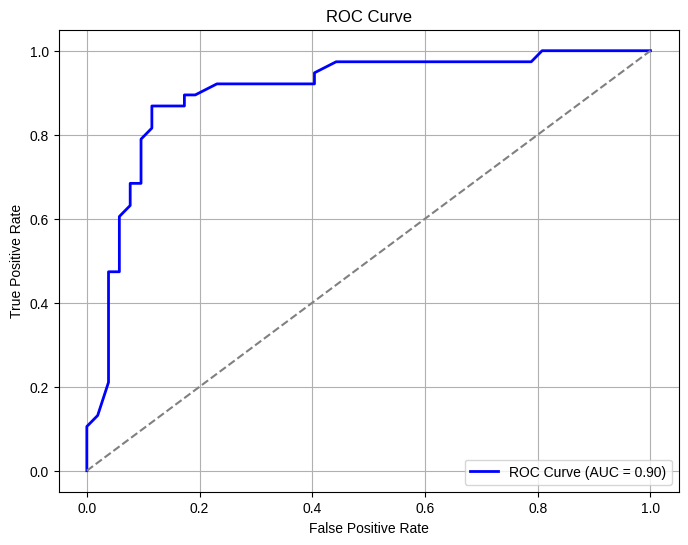

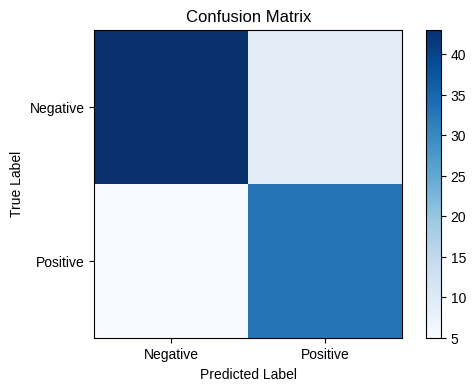

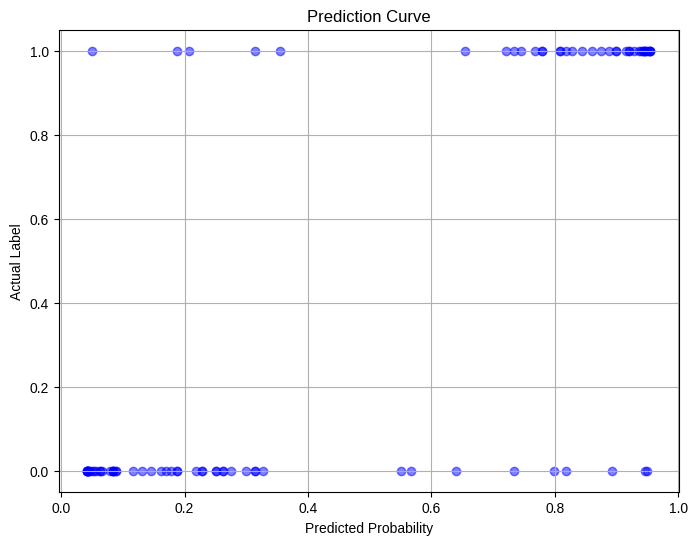

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming DF1 is already prepared and split into X_train, X_test, y_train, y_test
# Train your dual-stage stacked model on X_train and y_train

# Example of a simple dual-stage stacked model (you can replace this with your own model)
model_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_stage2 = LogisticRegression()

# Stage 1: Fit and predict
model_stage1.fit(X_train, y_train)
X_train_stage2 = model_stage1.predict_proba(X_train)[:, 1]
X_test_stage2 = model_stage1.predict_proba(X_test)[:, 1]

# Stage 2: Fit and predict
model_stage2.fit(X_train_stage2.reshape(-1, 1), y_train)
y_prob_test = model_stage2.predict_proba(X_test_stage2.reshape(-1, 1))[:, 1]

# Calculate ROC-AUC score
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
roc_auc = roc_auc_score(y_test, y_prob_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Confusion Matrix
y_pred = (y_prob_test > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.show()

# Plot Prediction Curve (optional)
plt.figure(figsize=(8, 6))
plt.scatter(y_prob_test, y_test, color='blue', alpha=0.5)
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Label')
plt.title('Prediction Curve')
plt.grid()
plt.show()
